#### Here's the plan...

- read Bishop re: generalized linear models
- select a data set
    - http://archive.ics.uci.edu/ml/datasets/Cuff-Less+Blood+Pressure+Estimation  3 attributes, so good for visualisation
    - http://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant 4 attributes
    - http://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength everyone loves concrete
- try fitting a few different models
    - linear regression
    - ridge regression
    - lasso
    - bayesian regression
    - MLP using Keras
- comment on the models, their cost functions, training algorithms, advantages and disadvantages
- assess the models by
    - cross validation
    - residuals?
- other things to look into
    - heteroscedasticity
    - non-normal errors
    - basis functions

#### Combined-Cycle Power Plant (CCPP)

The data show the power output (MW) for a combined-cycle power plant along with 4 other measurements: ambient temperature (deg C), ambient pressure (mbar), relative humidity (%) and exhaust vacuum (cm Hg).

In [1]:
import pandas as pd

data_filepath = "C:/Users/tom/Documents/datasets/CCPP/CCPP_data.csv"
data = pd.read_csv(data_filepath)
data.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


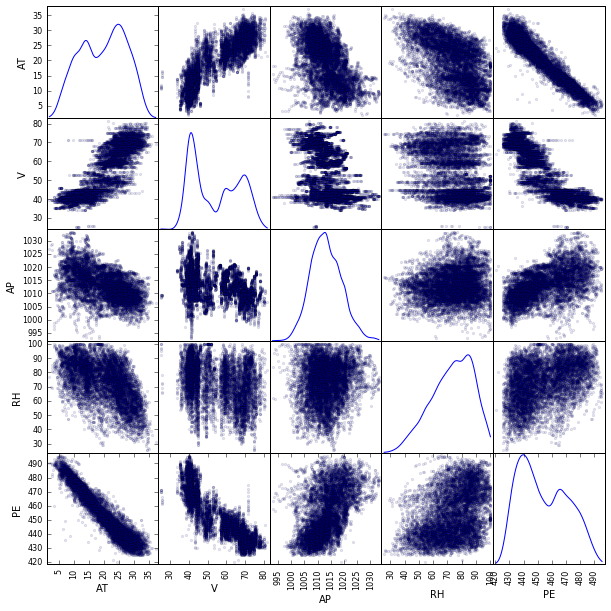

In [2]:
%matplotlib inline
scatter_axes = pd.scatter_matrix(data, diagonal='kde', alpha=0.1, figsize=(10,10))

Initial observations:
- Power is strongly negatively correlated with ambient temperature
- Power is also negatively correlated with exhaust vacuum.  
- However, exhaust vacuum and temperature are positively correlated, so there may be little benefit to using both AT and V in a predictive model.  Can we assume that V is causally dependent on AT?
- Exhaust vacuum does not appear to depend strongly on either ambient pressure or relative humidity
- Ambient temperature and pressure are slightly negatively correlated.
- Exhaust vacuum, ambient temperature and power output are all bi-modally distributed.  Is this driven by the bi-modal temperature distribution?

Quantify these observations by looking at the correlation matrix.

In [3]:
data.corr()

,AT,V,AP,RH,PE
AT,1.000000,0.844107,-0.507549,-0.542535,-0.948128
V,0.844107,1.000000,-0.413502,-0.312187,-0.869780
AP,-0.507549,-0.413502,1.000000,0.099574,0.518429
RH,-0.542535,-0.312187,0.099574,1.000000,0.389794
PE,-0.948128,-0.869780,0.518429,0.389794,1.000000


#### Linear Regression

Compare linear regression models based on:
- AT only
- V only
- AT and V (the strong correlation between these two could cause fitting problems for a linear model)
- AT, V and AP
- AT, V, AP and RH
- The first principal component
- The first two principal components
- Could try all 15 possible combinations of independent variables.

How should the data be split into training and test sets to compare the models?  There is no parameter tuning to be done on these models, so the data could simply be split into training and test sets.  However, we can try multiple training/test splits to also get an idea of the variance in performance for each model given different training data.  This can be achieved by appling k-fold cross validation, which will additionally ensure that every data point is used for testing at some point in the procedure.

In [20]:
from sklearn import linear_model
import numpy as np

x1 = np.array(data['AT'].iloc[0:5000]).reshape(-1,1)
x2 = np.array(data['V'].iloc[0:5000]).reshape(-1,1)
y1 = np.array(data['PE'].iloc[0:5000])
y2 = np.array(data['PE'].iloc[0:5000])
lm1 = linear_model.LinearRegression()
lm2 = linear_model.LinearRegression()
lm1.fit(x1,y1)
lm2.fit(x2,y2)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

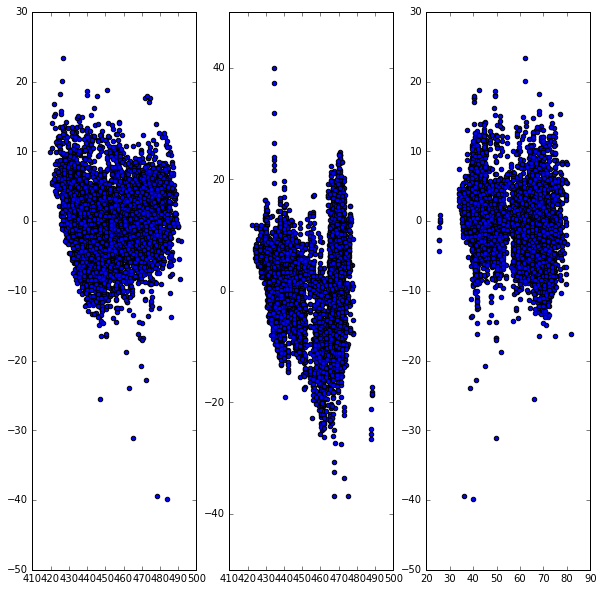

In [21]:
y1_predicted = lm1.predict(x1)
r1 = y1 - y1_predicted

y2_predicted = lm2.predict(x2)
r2 = y2 - y2_predicted

%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)
ax1.scatter(y1_predicted, r1)
ax2.scatter(y2_predicted, r2)
ax3.scatter(x2, r1)

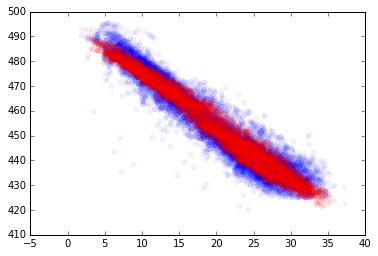

In [131]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plot.figure()
ax = fig.add_subplot(1,1,1)
# ax.scatter(np.array(data['AT'].iloc[0:5000]), y1, alpha=0.05, color='b')
# ax.scatter(np.array(data['AT'].iloc[5000:]), y2, alpha=0.05, color='g')
ax.scatter(np.array(data['AT']), y, alpha=0.05, color='b')
ax.scatter(np.array(data['AT']), models[0][2].predict(np.array(data[models[0][0]])), alpha=0.05, color='r')
# ax.plot(np.linspace(1, 38, 100), lm1.predict(np.linspace(1, 38, 100).reshape(-1,1)), color='r')
# ax.plot(np.linspace(1, 38, 100), lm2.predict(np.linspace(1, 38, 100).reshape(-1,1)), color='k')

In [134]:
def compare_linear_models(data, regressor_names, regressand_name, num_folds=2):
    
    from sklearn import linear_model
    import sklearn.cross_validation as cv
    import numpy as np
    
    # Create an empty list to hold the data to be returned
    output = []
    
    # Create the training and test sets
    kf = cv.KFold(data.shape[0], num_folds, shuffle=True)
    
    # Extract the regressand target values
    y = data[regressand_name]
    
    # Train the models specified by the feature_names list
    for names in regressor_names:
        
        # Extract the regressor names
        X = np.array(data[names])
        X = X.reshape(-1,1) if len(X.shape) == 1 else X # sklearn linear model cannot accept a 1D input array
        
        # Train the model on each fold of the data
        #for train, test in kf:
            # lm = linear_model.LinearRegression()
            # lm.fit(X[train], y[train])
            
        scores = cv.cross_val_score(linear_model.LinearRegression(), X, y, scoring='r2', cv=kf)
        output.append([names, scores, linear_model.LinearRegression().fit(X, y)])
        # scores = cv.cross_val_score(linear_model.Ridge(alpha=0), X, y, scoring='r2', cv=kf)
        # output.append([names, scores, linear_model.Ridge(alpha=0).fit(X, y)])    
        
    return output
    

In [135]:
models = compare_linear_models(data, [['AT', 'V', 'AP', 'RH'], ['AT'], ['RH'], ['V'], ['AT', 'V']], 'PE', 10)
models

[[['AT', 'V', 'AP', 'RH'],
  array([ 0.93299997,  0.92654804,  0.93441126,  0.92988964,  0.92748028,
          0.93171239,  0.91687442,  0.93483406,  0.9238716 ,  0.92757686]),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)],
 [['AT'],
  array([ 0.90041364,  0.89462406,  0.90260465,  0.90427407,  0.90026182,
          0.89710619,  0.88708527,  0.90275313,  0.89888505,  0.90065276]),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)],
 [['RH'],
  array([ 0.10934716,  0.15561956,  0.12766412,  0.16771362,  0.16672096,
          0.16571382,  0.16242598,  0.12374565,  0.15111339,  0.18286548]),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)],
 [['V'],
  array([ 0.74727297,  0.75726297,  0.7579752 ,  0.75246432,  0.77605815,
          0.76386654,  0.73987367,  0.76210837,  0.75306273,  0.7534344 ]),
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)],
 [['AT', 'V'],
  arr

In [124]:
print(models[0][2].coef_)
print(models[0][2].intercept_)

[-1.97751311 -0.23391642  0.06208294 -0.1580541 ]
454.609274315


In [130]:
print(models[0][2].coef_)
print(models[0][2].intercept_)

[-1.95025399 -0.24283101  0.0554912  -0.1503148 ]
460.669497371


- Confirm that cv calculates the score on the validation fold.
- Hold out a test set a compare cv scores to test set score.
